 # B1. Data set selection and description
For this project we are aiming to differentiate between a real movie review and a bot/AI generated review. To do this we have collected a huge number of real movie reviews which we have got from this website of cornell university called [The Movie Review Data](http://www.cs.cornell.edu/people/pabo/movie-review-data/). This website has review data in different formats but since we are interested to work with subjective and qualitative data we took the ones with the text reviews. The archive file has almost 1400 review as text files sorted as positive and negative. Since we have a bottleneck in generating fake movie review we picked only 250 positive and 250 negative = 500 real movie reviews. After getting the real reviews we have tried to find the online dataset sources where we could find fake reviews but we could not find any dataset or website with text where there are fake/AI generated movie review data. So we decided to generate AI written movie reviews from an website called [inferkit](https://app.inferkit.com/generate). Since we want to make our data balanced we made a batch request of creating reviews of 500 movies which returned us with an csv file with movie name and corresponding generated review. Now we have a balanced dataset of 500+500 movie reviews and we will move to our next step.

In [37]:
import glob

import pandas as pd
import os


# B3. Data preparation including transforms, scaling, re-shaping and any feature selection to reduce dimensionality. Summary of cleaned/pre-processed data.
Our data is stored in the `data` folder where we have the **_fake_** reviews stored in the `generated_reviews_500.csv` and the **_real_** reviews are stored as text files in the `real_reviews` folder

In [38]:
def read_files(text_files_dir):
    path = text_files_dir
    files = glob.glob(os.path.join(path, '*.txt'))
    real_reviews = []
    for file in files:
        with open(file, 'r') as f:
            real_reviews.append(f.read())

    return real_reviews


reviews_list = read_files('data/real_reviews')
# convert it to a pandas dataframe
reviews_real = pd.DataFrame(reviews_list, columns=['text'])
print(reviews_real.head())

reviews_generated = pd.read_csv('data/generated_reviews_500.csv')
reviews_generated.head()

                                                text
0  an attempt at florida film noir , palmetto fai...
1  birthdays often cause individuals to access th...
2  summer catch ( 2001 ) . starring freddie prinz...
3  as far as " mystery men " is concerned , the b...
4  the team who brought us 'a fish called wanda' ...


,prompt_index,prompt_text,completion_index,completion,full_text,reached_end
0,0,A review of The Social Network,0,", the movie about the founding of Facebook, ha...","A review of The Social Network, the movie abou...",False
1,1,A review of The Last Witch Hunter,0,", a new action-horror film from director Neill...","A review of The Last Witch Hunter, a new actio...",False
2,2,A review of Victor Frankenstein,0,\n\nThe Frankenstein Chronicles\n\nA review of...,A review of Victor Frankenstein\n\nThe Franken...,False
3,3,A review of A Street Cat Named Bob,0,", by James Bowen\n\nA Street Cat Named Bob, by...","A review of A Street Cat Named Bob, by James B...",False
4,4,A review of Green Room,0,\n\nGreen Room\n\nDirected by Jeremy Saulnier\...,A review of Green Room\n\nGreen Room\n\nDirect...,False


### Transforms
we are dropping all columns except the **_full_text_** and renaming it to **_text_** to keep it consistent with the dataframe containing real reviews

In [39]:
# drop all columns except the full_text column
reviews_generated = reviews_generated.drop(['prompt_index',
                                            'prompt_text',
                                            'completion_index',
                                            'completion',
                                            'reached_end'],
                                           axis=1)
# rename the full_text column to text
reviews_generated = reviews_generated.rename(columns={'full_text': 'text'})
reviews_generated.columns

Index(['text'], dtype='object')

after this we are adding a new column to both data frames named **label** containing boolean value. **1** means a real review and **0** means a fake or generated review

In [40]:
reviews_real['label'] = 1
print(reviews_real.head())
print(len(reviews_real))

reviews_generated['label'] = 0
print(reviews_generated.head())
print(len(reviews_generated))


                                                text  label
0  an attempt at florida film noir , palmetto fai...      1
1  birthdays often cause individuals to access th...      1
2  summer catch ( 2001 ) . starring freddie prinz...      1
3  as far as " mystery men " is concerned , the b...      1
4  the team who brought us 'a fish called wanda' ...      1
500
                                                text  label
0  A review of The Social Network, the movie abou...      0
1  A review of The Last Witch Hunter, a new actio...      0
2  A review of Victor Frankenstein\n\nThe Franken...      0
3  A review of A Street Cat Named Bob, by James B...      0
4  A review of Green Room\n\nGreen Room\n\nDirect...      0
500


### Scaling, Re-shaping & Reducing Dimensionality

Now we will merge these 2 dataframes and shuffle them for better mix of data before training

In [41]:
# merge the two dataframes
reviews = pd.concat([reviews_real, reviews_generated], ignore_index=True)
# random shuffle the dataframe
reviews = reviews.sample(frac=1).reset_index(drop=True)
print(reviews.head())

                                                text  label
0  A review of Handsome Devil\n\nA review of Hand...      0
1  A review of The Love Witch, the latest film fr...      0
2  starring woody harrelson , antonio banderas , ...      1
3   the thing about adam sandler is , his heart i...      1
4  A review of The Incredible Hulk #1 by Jeph Loe...      0


### Performing Basic Clean up

For building better corpus we are clean up the punctuations, stopwords and removing all the capitalization

In [42]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# perform cleanup in the text column
# remove all new line characters
reviews['text'] = reviews['text'].str.replace('\n', ' ')
# remove all non-alphabetic characters
reviews['text'] = reviews['text'].str.replace('[^a-zA-Z]', ' ')
# convert all text to lowercase
reviews['text'] = reviews['text'].str.lower()
# remove all stopwords
reviews['text'] = reviews['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
reviews.head()

C:\Users\fazal_ix0ll8n\AppData\Local\Temp\ipykernel_12004\2980047144.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews['text'] = reviews['text'].str.replace('[^a-zA-Z]', ' ')


,text,label
0,review handsome devil review handsome devil fa...,0
1,review love witch latest film director anna bi...,0
2,starring woody harrelson antonio banderas loli...,1
3,thing adam sandler heart right place example h...,1
4,review incredible hulk jeph loeb tim sale incr...,0


# B2. Dataset analysis, visualisation, feature correlation, insights extracted from data visualisation

### Feature Correlation
Since we are doing binary text classification we assume that our Label and Texts are already correlated.

### Visualization and Insights from extracted data

Here, we will visualize the words that appear most in the whole corpus/the complete text.

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fazal_ix0ll8n\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fazal_ix0ll8n\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fazal_ix0ll8n\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fazal_ix0ll8n\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
E:\Fazal Mahmud Niloy\Study\UC niloy\PRML\Assignment 2\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


aa         0.241901
aaa        0.271615
aamir      0.160972
aaron      1.121402
ab         0.064179
             ...   
zuko       0.147215
zuvela     0.152195
zwick      0.450252
zwigoff    0.061374
zylka      0.180085
Length: 18680, dtype: float64


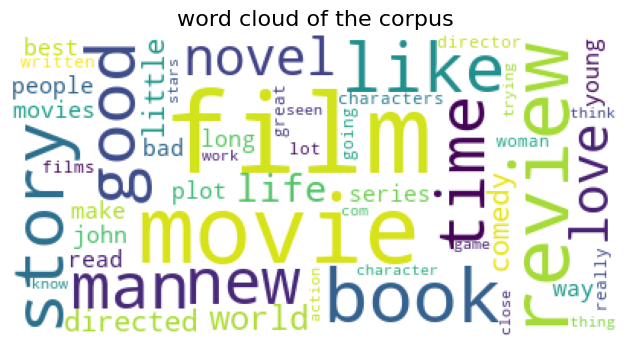

In [43]:
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

corpus = reviews['text'].tolist()

vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)
print(df.T.sum(axis=1))
cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(df.T.sum(axis=1))
plt.gca().imshow(cloud)
plt.gca().set_title('word cloud of the corpus', fontdict=dict(size=16))
plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


### WordCloud of Real Reviews

E:\Fazal Mahmud Niloy\Study\UC niloy\PRML\Assignment 2\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


aa         0.238909
aaa        0.120939
aaron      0.532918
ab         0.065238
aback      0.117717
             ...   
zorro      0.080943
zudina     0.078181
zuko       0.149438
zwick      0.336092
zwigoff    0.061165
Length: 17026, dtype: float64


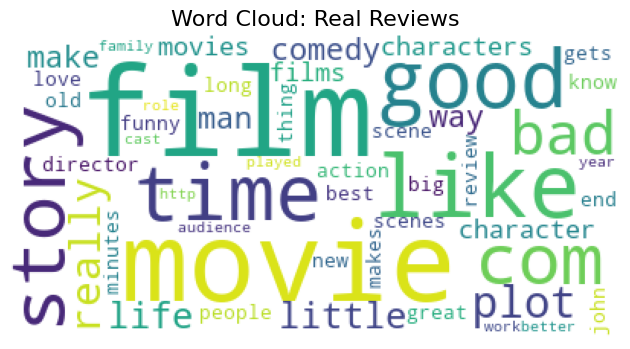

In [44]:
# take rows where lable is 1
real_reviews = reviews[reviews['label'] == 1]

corpus = real_reviews['text'].tolist()

vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)
print(df.T.sum(axis=1))
cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(df.T.sum(axis=1))
plt.gca().imshow(cloud)
plt.gca().set_title('Word Cloud: Real Reviews', fontdict=dict(size=16))
plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Word Cloud of Fake reviews

E:\Fazal Mahmud Niloy\Study\UC niloy\PRML\Assignment 2\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


aaa          0.138213
aamir        0.148418
aaron        0.619128
abandoned    0.146599
abc          0.239646
               ...   
zoolander    0.594624
zoologist    0.135385
zuvela       0.137912
zwick        0.130380
zylka        0.152761
Length: 5155, dtype: float64


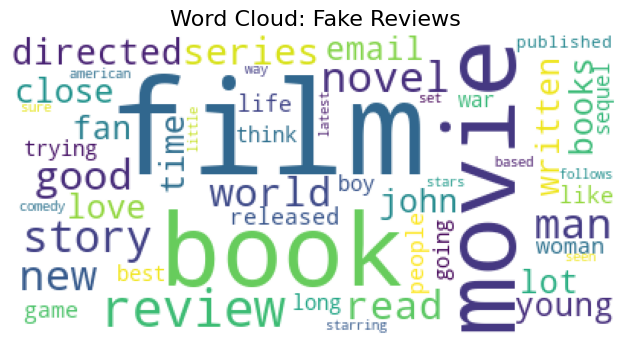

In [45]:
# take rows where lable is 0
fake_reviews = reviews[reviews['label'] == 0]
corpus = fake_reviews['text'].tolist()

vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)
print(df.T.sum(axis=1))
cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(df.T.sum(axis=1))
plt.gca().imshow(cloud)
plt.gca().set_title('Word Cloud: Fake Reviews', fontdict=dict(size=16))
plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# B4. Selection of 3-4 algorithms most appropriate. Justify your selection.

In this section we will run 4 algorithms for modeling and based on accuracy we will decide which model goes with our dataset best. The models are:

1. Naive Bayes
2. Support Vector Machine
3. Logistic Regression
4. Random Forest

In [46]:
# run naive bayes on the data
# split the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews['text'], reviews['label'], test_size=0.2, random_state=42)

# vectorize the text
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# train the model
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)

# evaluate the model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(X_test)
print('========= Naive Bayes =========')
print('Accuracy: ')
print(accuracy_score(y_test, y_pred))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification Report: ')
print(classification_report(y_test, y_pred))
print('======================================================')
print()


# run svm on the data
# train the model
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)

# evaluate the model
y_pred = model.predict(X_test)
print('========= SVM =========')
print('Accuracy: ')
print(accuracy_score(y_test, y_pred))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification Report: ')
print(classification_report(y_test, y_pred))
print('======================================================')
print()

# run logistic regression on the data
# train the model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

# evaluate the model
y_pred = model.predict(X_test)
print('========= Logistic Regression =========')
print('Accuracy: ')
print(accuracy_score(y_test, y_pred))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification Report: ')
print(classification_report(y_test, y_pred))
print('======================================================')
print()

# run random forest on the data
# train the model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

# evaluate the model
y_pred = model.predict(X_test)
print('========= Random Forest =========')
print('Accuracy: ')
print(accuracy_score(y_test, y_pred))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification Report: ')
print(classification_report(y_test, y_pred))
print('======================================================')
print()

========= Naive Bayes =========
Accuracy: 
0.81
Confusion Matrix: 
[[64 38]
 [ 0 98]]
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       102
           1       0.72      1.00      0.84        98

    accuracy                           0.81       200
   macro avg       0.86      0.81      0.80       200
weighted avg       0.86      0.81      0.80       200


========= SVM =========
Accuracy: 
0.99
Confusion Matrix: 
[[100   2]
 [  0  98]]
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       102
           1       0.98      1.00      0.99        98

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200


========= Logistic Regression =========
Accuracy: 
0.985
Confusion Matrix: 
[[99  3]
 [ 0 98]]
Classification Report: 
         

#### As we can see Naive Bayes has the lowes accuracy among these 4 algorithms. So initially we can omit Naive Bayes from our candidate as model building algorithms. Finally, we can say that the last 4 are the best initial algorithms for our project.